In [1]:
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ladowanie danych
awards = pd.read_csv("./data/awards.csv")
body_builders = pd.read_csv("./data/body_builders.csv")
coaches = pd.read_csv("./data/coaches.csv")
countries = pd.read_csv("./data/countries.csv")
matches = pd.read_csv("./data/matches.csv")
physiotherapists = pd.read_csv("./data/physiotherapists.csv")
players = pd.read_csv("./data/players.csv")
presidents = pd.read_csv("./data/presidents.csv")
press_offices = pd.read_csv("./data/press_offices.csv")
sport_directors = pd.read_csv("./data/sport_directors.csv")
stadiums = pd.read_csv("./data/stadiums.csv")
statisticians = pd.read_csv("./data/statisticians.csv")
team_mangers = pd.read_csv("./data/team_mangers.csv")
teams = pd.read_csv("./data/teams.csv")
transfers = pd.read_csv("./data/transfers.csv")

In [3]:
polish_teams = teams[teams["country_code"] == "PL"]
polish_players = players[players["country_code"] == "PL"]

<Figure size 1000x1000 with 0 Axes>

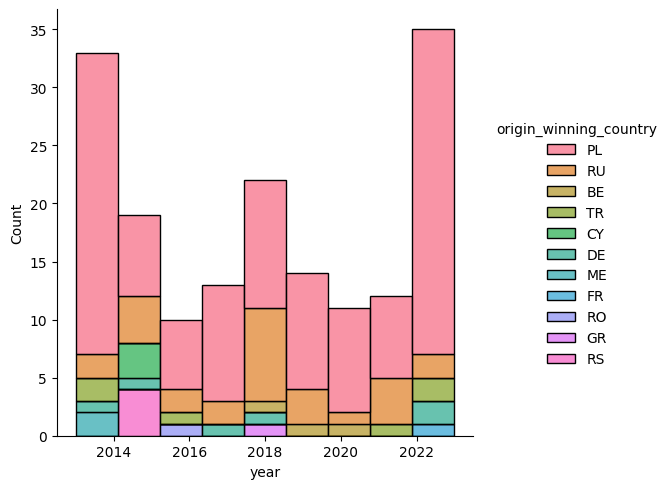

In [4]:
# merge metches with team
matches_have_id = matches["first_team_id"].notna() & matches["second_team_id"].notna()
teams_slice = teams[["country_code", "team_id", "team_name"]]
mt = matches[matches_have_id]
mt = mt.merge(teams_slice, left_on="first_team_id", right_on="team_id").rename(
    columns={"country_code": "first_team_country_code", "team_name": "first_team_name"}
)
mt = mt.merge(teams_slice, left_on="second_team_id", right_on="team_id").rename(
    columns={
        "country_code": "second_team_country_code",
        "team_name": "second_team_name",
    }
)
mt["origin_winning_country"] = np.where(
    mt["n_set_team1"] > mt["n_set_team2"],
    mt["first_team_country_code"],
    mt["second_team_country_code"],
)
plt.figure(figsize=(10, 10))

is_polish_team_against_other = ((mt['first_team_country_code'] == 'PL') | (mt['second_team_country_code'] == 'PL')) &  ~((mt['first_team_country_code'] == 'PL') & (mt['second_team_country_code'] == 'PL'))
polish_vs_other = mt[is_polish_team_against_other]
polish_vs_other['year'] = pd.to_datetime(polish_vs_other['date'], format='%m/%d/%Y').dt.year 
sns.displot(data=polish_vs_other, x="year", hue="origin_winning_country", multiple="stack")
plt.show()

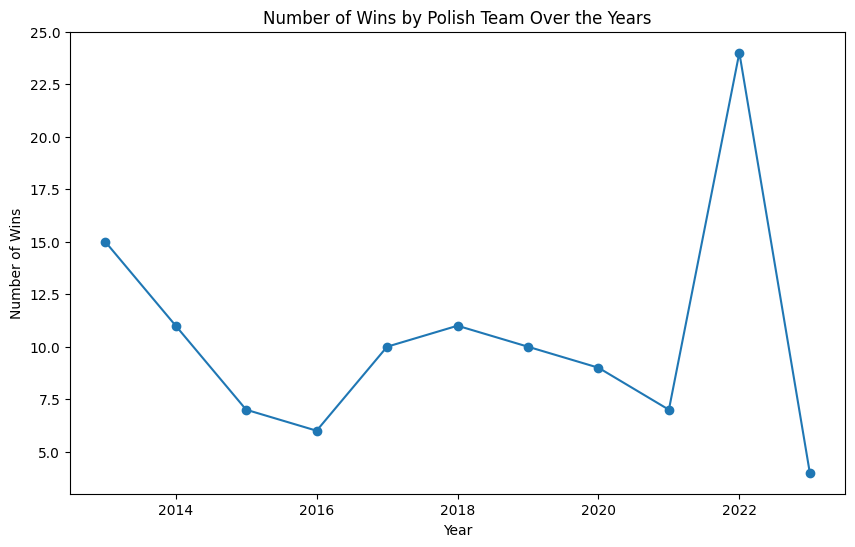

In [5]:
plt.figure(figsize=(10, 6))
polish_wins = polish_vs_other[polish_vs_other['origin_winning_country'] == 'PL']
polish_wins_by_year = polish_wins['year'].value_counts().sort_index()
polish_wins_by_year.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.title('Number of Wins by Polish Team Over the Years')
plt.show()

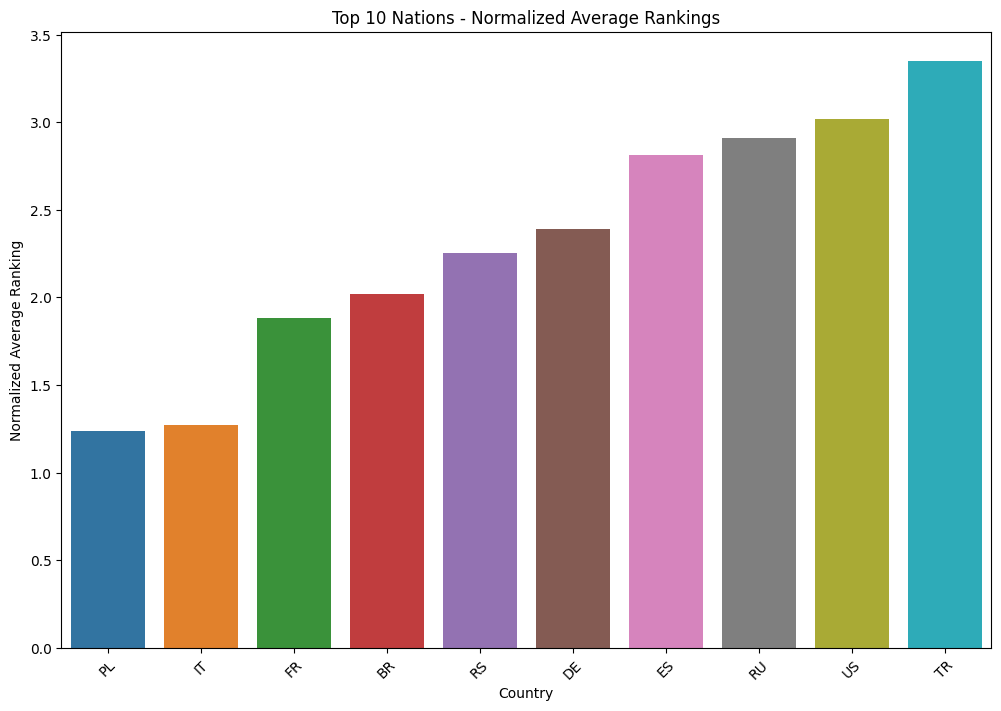

In [6]:

players_nona = players.dropna(subset=['ranking'])
average_ranking = players_nona.groupby('country_code')['ranking'].mean()
player_count = players['country_code'].value_counts()
normalized_ranking = average_ranking / player_count
top_teams = normalized_ranking.sort_values(ascending=True)
top_teams = top_teams[top_teams > 0].head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_teams.index, y=top_teams.values)
plt.title('Top 10 Nations - Normalized Average Rankings')
plt.xlabel('Country')
plt.ylabel('Normalized Average Ranking')
plt.xticks(rotation=45)
plt.show()


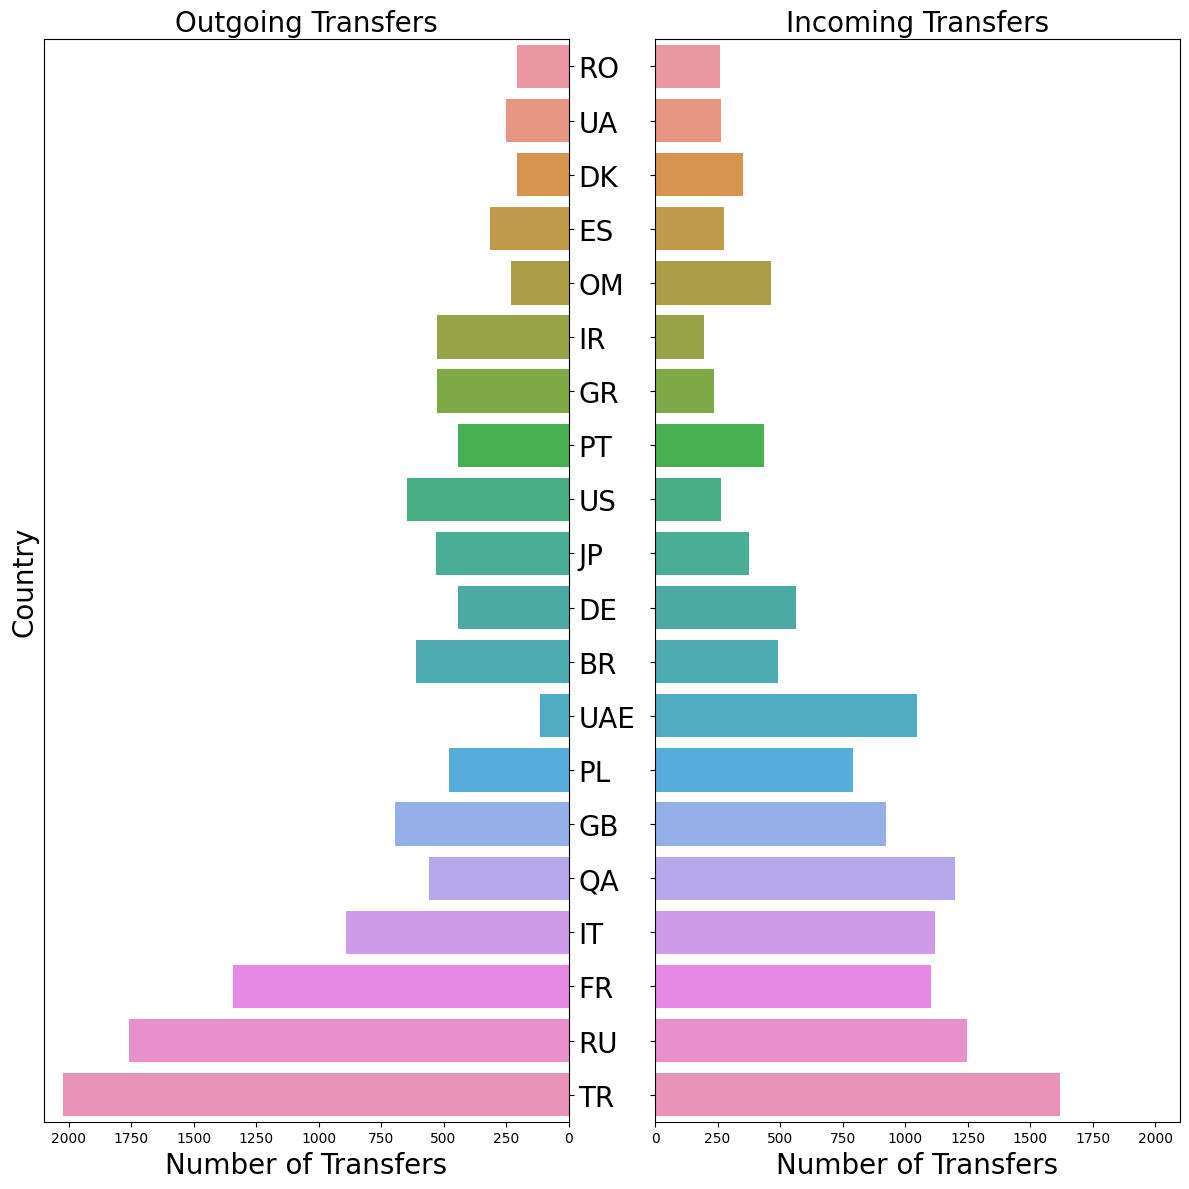

In [32]:
transfers_country = transfers.merge(teams, left_on='old_team_id', right_on='team_id', how='left')
transfers_country = transfers_country.merge(teams, left_on='new_team_id', right_on='team_id', how='left')

transfer_countries_old = transfers_country['country_code_x'].value_counts()
transfer_countries_new = transfers_country['country_code_y'].value_counts()

transfer_countries_sum = transfer_countries_old.add(transfer_countries_new, fill_value=0)
transfer_countries_sum = transfer_countries_sum.sort_values(ascending=True)
transfer_countries_new = transfer_countries_new.reindex(transfer_countries_sum.index).tail(20)
transfer_countries_old = transfer_countries_old.reindex(transfer_countries_sum.index).tail(20)


fig, ax = plt.subplots(1, 2, figsize=(12, 12), sharey='all')
plt.subplots_adjust(wspace=0.4)

ax[0].set_yticklabels(transfer_countries_old.index, fontsize=20)
ax[1].set_yticklabels(transfer_countries_old.index, fontsize=14)

ax[1].set_xlim([0, 2100])
ax[0].set_xlim([2100, 0])

ax[0].set_ylabel('Country', fontsize=20)
ax[1].set_xlabel('Number of Transfers', fontsize=20)
ax[0].set_xlabel('Number of Transfers', fontsize=20)
ax[0].set_title('Outgoing Transfers', fontsize=20)
ax[1].set_title('Incoming Transfers', fontsize=20)
ax[0].yaxis.tick_right()

sns.barplot(y=transfer_countries_old.index, x=transfer_countries_old.values, ax=ax[0])
sns.barplot(y=transfer_countries_new.index, x=transfer_countries_new.values, ax=ax[1])
plt.tight_layout()
plt.show()


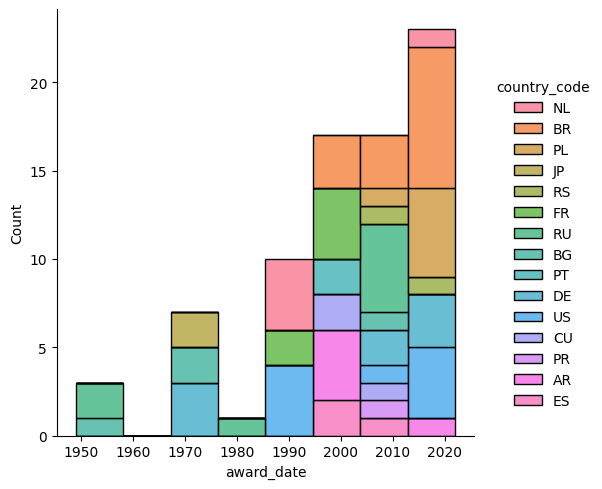

In [8]:
leagues_global = [
    'World Championships', 'World League', 'World Cup', 'The Olympics',
    'The Olympic Qualification', 'European Championships', 
    'European Supercup', 'Volleyball Nations League',
    'Champions League', 'CEV Olympic Qualification'
]

aws = [awards[awards['league'] == ll] for ll in leagues_global]
awards_league_global = pd.DataFrame(aws[0])
[awards_league_global._append(aw) for aw in aws[1:]]

awards_with_players = awards_league_global.merge(players, on='player_id', how='left')
award_counts = awards_with_players.groupby(["award_date", "country_code"]).size().reset_index(name="count")
sorted_awards = award_counts.sort_values("count", ascending=False).head(40)
filtered_awards = awards_with_players.merge(sorted_awards, on=["award_date", "country_code"], how="inner")
sns.displot(data=filtered_awards, x="award_date", hue="country_code", multiple="stack")
plt.show()

In [9]:
transfers_collapsed = transfers.drop_duplicates(subset=['player_name', 'old_team_id', 'new_team_id'], keep='first', inplace=False, ignore_index=False)
not_nan = transfers_collapsed['new_team_id'].notna()
transfers_collapsed[not_nan]

,transfer_id,player_name,first_name,last_name,date,old_team_id,new_team_id
0,1,Thiago Maciel,Thiago,Maciel,2010,t2579,t1454
2,3,Dante Elias Trevisan,Dante,Trevisan,2010,t1517,t1309
4,5,Arash Keshavarzi,Arash,Keshavarzi,2010,t1753,t2398
5,6,Mario Zelić,Mario,Zelić,2010,t1535,t1821
6,7,Dmitry Shestak,Dmitry,Shestak,2010,t1929,t1472
...,...,...,...,...,...,...,...
21800,21801,Luca Ramon,Luca,Ramon,2023,t1674,t1895
21802,21803,Abdulkadir Terlik,Abdulkadir,Terlik,2023,t20873,t16956
21804,21805,Tom Picard,Tom,Picard,2023,t1323,t1849
21806,21807,Antoine Pothron,Antoine,Pothron,2023,t1849,t1895


In [11]:
awards.head()

,award_id,player_id,award_name,league,award_date
0,1,p19068,Best opposite,French Ligue B,2017
1,2,p59784,Best setter,Icelandic League,2022
2,3,p56840,Best setter,NEVZA U17,2021
3,4,p464,Best setter,Finnish Lentopallon Mestaruusliiga,2017
4,5,p78692,Best outside hitter,Balkan Championships U18,2022


In [12]:
body_builders.head()

,body_builder_id,first_name,last_name,birth_date,team_id
0,1,Pablo,Gianelli,10/30/1989,NaN
1,2,David,Barroso,10/31/1996,NaN
2,3,Ioannis,Paraschidis,8/24/1989,NaN
3,4,Ramin,Aqai),3/2/1990,t16281
4,5,Eduardo,1000,NaN,NaN


In [13]:
coaches.head()

,first_name,last_name,weight,height,birth_date,team_id
0,José,uis Rifourcat (Josi),0.0,0.0,NaN,NaN
1,Agim,Reka,0.0,0.0,6/8/1963,NaN
2,Nahuel,Fernando López,0.0,0.0,NaN,NaN
3,Blerim,Pepa,0.0,0.0,11/9/1985,NaN
4,Miguel,Benjamin Pantorrilla Perez (Profe.),0.0,0.0,10/20/1975,t19353


In [14]:
countries.head()

,country_code,country_name
0,AD,Andorra
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Antigua and Barbuda
4,AI,Anguilla


In [15]:
matches.head()

,match_id,name,date,league,n_set_team1,n_set_team2,first_team_id,second_team_id
0,1,Sports Palace Hall,3/9/2023,West Asian Club Championship,0,3,t9687,t10276
1,2,Sir Stanley Matthews Sports Centre,3/11/2023,English Super League,3,1,t6592,t1830
2,3,Halle des Sports Louis Marty,3/11/2023,French Ligue A,2,3,t1323,t1674
3,4,Volksbank-Arena,3/11/2023,German Bundesliga,3,0,NaN,NaN
4,5,Sports Palace Hall,3/9/2023,West Asian Club Championship,3,2,NaN,NaN


In [16]:
physiotherapists.head()

,first_name,last_name,birth_date,team_id
0,Maja,Mühlemann,NaN,NaN
1,Palvita,Kalaj,4/21/1986,t3801
2,Perli,Rusi,NaN,NaN
3,Philippe,Currat,NaN,NaN
4,Olta,Zajmi,11/5/1993,NaN


In [17]:
players.head()

,player_id,name,ranking,weight,position,height,country_code,birthdate
0,p1,Enea Xhelati,2659.0,91.0,Opposite,200.0,NaN,5/15/1982
1,p10,Demián González TOP 200,159.0,81.0,Setter,192.0,AR,2/21/1983
2,p100,Wannes Rosiers,NaN,86.0,Opposite,201.0,BE,6/22/1985
3,p1000,Ivan Borovnjak,1902.0,88.0,Outside Hitter,200.0,RS,7/4/1989
4,p10000,Szymon Kostecki,NaN,NaN,Outside Hitter,190.0,PL,9/23/1981


In [18]:
presidents.head()

,president_id,first_name,last_name,birthdate,team_id
0,1,Joos,Gysen,NaN,t2795
1,2,Gerdi,De Kimpe,NaN,NaN
2,3,Philippe,Rassat,NaN,NaN
3,4,Stéphane,ouezy,5/23/1983,NaN
4,5,Daniël,anden Berghe,5/12/1954,NaN


In [19]:
press_offices.head()

,press_office_id,first_name,last_name,birthdate,team_id
0,2,Henk,Silversmet,NaN,t2694
1,3,Jochen,Gerardi,NaN,NaN
2,4,Luc,Meynckens,NaN,NaN
3,5,Franky,Van de Casteele,NaN,NaN
4,6,Filip,Rossel,NaN,NaN


In [20]:
sport_directors.head()

,sport_director_id,first_name,last_name,birthdate,team_id
0,1,Ron,Andelhof,1/26/1978,NaN
1,2,William,Ingels,NaN,NaN
2,3,Giuseppe,Cormio,NaN,NaN
3,4,Geert,De Dobbeleer,NaN,NaN
4,5,Giovanni,Guidetti TOP 100,9/20/1972,NaN


In [21]:
stadiums.head()

,stadium_id,stadium_name,country_code,town,opening_year,capacity
0,a1,Hamdan Sports Complex,UAE,Dubai,2010.0,15000.0
1,a10,Orfeo Superdomo,AR,Córdoba,2002.0,14000.0
2,a100,Centro de Entrenamiento Olimpico,CL,Santiago,NaN,2000.0
3,a1001,Ginásio Poliesportivo Municipal João Augusto T...,BR,Cabo Frio - RJ,NaN,NaN
4,a1002,Niigata Higashi General Sports Center,JP,Niigata,NaN,3120.0


In [22]:
statisticians.head()

,statisticians_id,first_name,last_name,birthdate,team_id
0,1,Elian,Quintans,NaN,NaN
1,2,Lucas,Alborch,1996-03-04,t17153
2,3,Javier,Oggier,1977-01-24,t5134
3,4,Matias,Serafin,1983-06-08,t20310
4,5,Hasan,Saračević,1992-08-14,NaN


In [23]:
team_mangers.head()

,team_manger_id,first_name,last_name,birthdate,team_id
0,1,Adrian,Villareal,NaN,NaN
1,2,Daniele,Torres,NaN,NaN
2,3,Jo,Santermans,NaN,NaN
3,4,Sandra,Vonk,NaN,t1842
4,5,Peter,Aebli,NaN,NaN


In [24]:
teams.head()

,team_id,team_name,country_code,n_matches,n_tournaments,town,founded
0,t10001,TSV Reinbek,DE,0,0,Reinbek,\r
1,t10016,Molde VBK,NO,0,0,Molde,\r
2,t10017,Al-Salam,SA,0,4,Qatif,\r
3,t10018,AZS Kraków,PL,0,14,Kraków,\r
4,t10019,Spójnia Warszawa,PL,0,3,Warszawa,1949


In [25]:
transfers

,transfer_id,player_name,first_name,last_name,date,old_team_id,new_team_id
0,1,Thiago Maciel,Thiago,Maciel,2010,t2579,t1454
1,2,Oleksandr Statsenko,Oleksandr,Statsenko,2010,t1617,NaN
2,3,Dante Elias Trevisan,Dante,Trevisan,2010,t1517,t1309
3,4,Robert Szczerbaniuk,Robert,Szczerbaniuk,2010,NaN,NaN
4,5,Arash Keshavarzi,Arash,Keshavarzi,2010,t1753,t2398
...,...,...,...,...,...,...,...
22275,22276,Vinicius Raguzzoni,Vinicius,Raguzzoni,2017,t1305,t1602
22276,22277,Marcus Nilsson,Marcus,Nilsson,2017,t5099,t1619
22277,22278,Javier Filardi,Javier,Filardi,2017,t1928,t1710
22278,22279,Alexander Petrov,Alexander,Petrov,2017,t2425,t1486


In [26]:
print(matches['league'].unique())

['West Asian Club Championship' 'English Super League' 'French Ligue A'
 'German Bundesliga' 'Indonesian Proliga' 'Azerbaijan League'
 'Bulgarian League' 'Kuwait League' 'Swiss League B' 'Bahrain League'
 'Israel Premier League' 'Dutch Eredivisie' 'French Ligue B'
 'Italian Serie A3' 'Albanian League' 'Champions League'
 'Polish Second League' 'Philippines Open Conference'
 'Finnish Lentopallon Mestaruusliiga' 'Argentinian Liga A1'
 'National 2 Poule B' 'National 2 Poule D' 'German Bundesliga 2.South'
 'National 2 Poule C' 'German Bundesliga 2.North' 'Brazilian Superliga'
 'Campeonato Nacional Juniores B Masculinos U21' 'Portuguese Cup'
 'Belgian Liga A' 'Portuguese  National Championship U21' 'UAAP'
 'Japan V.League Division 2' 'Japan V.League Division 3' 'Korean V-League'
 'Türkiye Erkekler Voleybol 1. Ligi' 'Russian Superleague'
 'Czech Extraliga' 'Polish PlusLiga' 'Italian Cup A3' 'Swiss League'
 'Estonian League' 'Norwegian Premier League' 'Slovakian Extraliga'
 'Japan V.League Di